### Building a Regression Model with ChemProp

This notebook shows how to build a ChemProp model.  The notebook borrows heavily from the ChemProp examples. 
1. Read the input data
2. Divide the dataset into training, validation, and test sets
3. Create the datasets
4. Create dataloaders
5. Create the model
6. Train the model
7. Predict the values for the test set
8. Evaluate the model

In [1]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
from chemprop import data, featurizers, nn, models
from lightning import pytorch as pl
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

### 1. Read the input data
Read the input data. For this exercise, we'll use one of the datasets from [this paper by Fang et al](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160). 

In [2]:
df = pd.read_csv("/Users/pwalters/software/benchmark/data/biogen_logS.csv")
y_col = "logS"

### 2. Divide the dataset into training, validation, and test sets.
Divide the dataset into training, validation, and test sets.

In [3]:
train_frac, val_frac, test_frac = 0.8, 0.1, 0.1
train, test = train_test_split(df, test_size=test_frac)
train, val = train_test_split(train, test_size=len(test))

Examine the sizes of the training, validation, and test sets.

In [4]:
len(train), len(val), len(test)

(1737, 218, 218)

### 3. Create the datasets
Convert the data to MoleculeDatapoints

In [5]:
train_pt = [data.MoleculeDatapoint.from_smi(smi, [y]) for smi, y in train[["SMILES", y_col]].values]
val_pt = [data.MoleculeDatapoint.from_smi(smi, [y]) for smi, y in val[["SMILES", y_col]].values]
test_pt = [data.MoleculeDatapoint.from_smi(smi, [y]) for smi, y in test[["SMILES", y_col]].values]

Create a featurizer to generate graph node and edge features for the molecules.

In [6]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

Create a training dataset by featurizing the training set, then scale the training set. 

In [7]:
train_dset = data.MoleculeDataset(train_pt, featurizer)
scaler = train_dset.normalize_targets()

Do the same with the validation dataset.  Use the scaler we created for the training set to scale the validation set. 

In [8]:
val_dset = data.MoleculeDataset(val_pt, featurizer)
val_dset.normalize_targets(scaler)

StandardScaler()

Create the test dataset and generate a scaler. 

In [9]:
test_dset = data.MoleculeDataset(test_pt, featurizer)
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

### 4. Create the dataloaders
Create dataloaders for the training validation and test sets.  

In [10]:
num_workers = 0
train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)

### 5. Create the model
Create the Feed Forward Neural Network (FFNN)

In [11]:
mp = nn.BondMessagePassing()
agg = nn.MeanAggregation()
ffn_input_dim = mp.output_dim
ffn = nn.RegressionFFN(input_dim=ffn_input_dim, output_transform=output_transform)

Create the Message Passing Neural Network (MPNN)

In [12]:
batch_norm = True
metric_list = [nn.metrics.RMSEMetric()]
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)

### 6. Train the model
Train the MPNN on the training and validation sets

In [13]:
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=False,
    enable_progress_bar=True,
    accelerator="cpu",
    devices=1,
    max_epochs=20,  # number of epochs to train for
)
trainer.fit(mpnn, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pwalters/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/pwalters/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

  | Name            | Type               | Params
-------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K 
1 | agg             | MeanAggregation    | 0     
2 | bn              | BatchNorm1d        | 600   
3

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/pwalters/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### 7. Predict the values for the test set
Predict the values for the test set. ChemProp returns the results from **predict** as an array of PyTorch tensors, which isn't particularly convenient. We'll fix that below. 

In [14]:
pred_tensor = trainer.predict(mpnn, test_loader)

/Users/pwalters/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [15]:
pred = np.array(list(itertools.chain(*pred_tensor))).flatten()

In [16]:
pred_df = pd.DataFrame({y_col: test[y_col], 'pred': pred})

### 8. Evaluate the model
Plot the experimental vs predicted values.

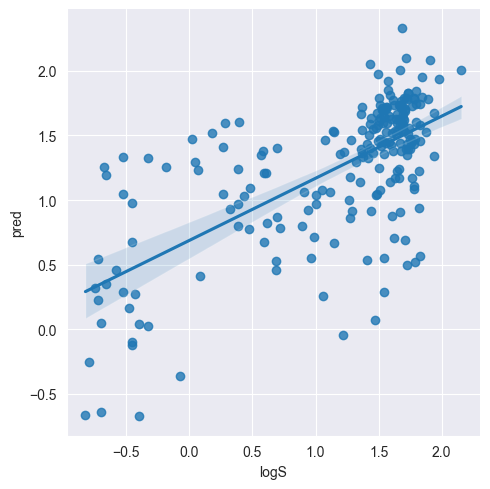

In [17]:
sns.lmplot(x=y_col, y="pred", data=pred_df)

In [18]:
r2_score(pred_df[y_col], pred)

0.42211003066079245

In [19]:
root_mean_squared_error(pred_df[y_col], pred)

0.5793351772660728